In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import ConvGVAEBuilder
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [2]:
config,_ = get_config()
setattr(config, 'batch_size', 128)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs', 5)
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'z_dim', 10)
setattr(config, 'recon',10)
setattr(config, 'log_dir', '../logs')
# setattr(config, 'xcov', None)
# setattr(config, 'recon', None)
prepare_dirs_and_logger(config)
vars(config)

{'batch_size': 128,
 'data_dir': 'data',
 'dataset': 'fashion_mnist',
 'enc_layers': [3000, 2000],
 'epochs': 5,
 'log_dir': '../logs',
 'log_level': 'INFO',
 'model_dir': '../logs/fashion_mnist_1009_002221',
 'model_name': 'fashion_mnist_1009_002221',
 'optimizer': 'adam',
 'recon': 10,
 'xcov': 10,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 10}

In [3]:
with open(os.path.join(config.model_dir,'params.json'), 'w') as fp:
    json.dump(vars(config), fp)

In [4]:
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
#                          translation=None,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.75
rot_max:  None
loading fashion_mnist...


  6%|▌         | 3689/60000 [00:00<00:01, 36880.80it/s]

sx_train:  (60000, 3136)
making training data...


 37%|███▋      | 3721/10000 [00:00<00:00, 37200.63it/s]

making testing data...


100%|██████████| 10000/10000 [00:00<00:00, 36500.11it/s]


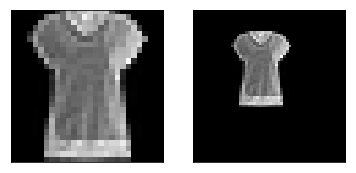

In [5]:
pt,idx = plot_ovt(DL,cmap='gray')

In [6]:
mod_builder = ConvGVAEBuilder(enc_layers=config.enc_layers,z_dim=config.z_dim)

In [7]:
trainer = Trainer(config,DL,mod_builder)

building model...


In [8]:
trainer.compile_model()

In [9]:
trainer.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
y_lat (Dense)                   (None, 10)           20010       dense_2[0][0]                    
__________________________________________________________________________________________________
z_lat (Den

In [10]:
trainer.go(x=DL.sx_train,y=DL.y_train_oh,validation_split=0.1,verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 10s 183us/step - loss: 1208.5021 - acc: 0.6400 - xentropy: 9.2675 - recon_mse: 55.2099 - val_loss: 977.6785 - val_acc: 0.7205 - val_xentropy: 7.4441 - val_recon_mse: 66.6677
Epoch 2/5
54000/54000 [==============================] - 8s 148us/step - loss: 888.4683 - acc: 0.7317 - xentropy: 6.8468 - recon_mse: 29.9674 - val_loss: 877.4051 - val_acc: 0.7382 - val_xentropy: 6.6982 - val_recon_mse: 53.6126
Epoch 3/5
54000/54000 [==============================] - 8s 150us/step - loss: 780.2733 - acc: 0.7630 - xentropy: 6.0107 - recon_mse: 26.8758 - val_loss: 854.1000 - val_acc: 0.7548 - val_xentropy: 6.4207 - val_recon_mse: 83.7882
Epoch 4/5
54000/54000 [==============================] - 8s 150us/step - loss: 709.1576 - acc: 0.7848 - xentropy: 5.4589 - recon_mse: 25.6520 - val_loss: 829.2619 - val_acc: 0.7637 - val_xentropy: 6.3996 - val_recon_mse: 29.5614
Epoch 5/5
54000/54000 [==========

In [11]:
trainer.save_model()

In [12]:
from keras.models import Model
from keras.layers import Input

In [18]:
z_encoder = trainer.get_encoder('z_lat')
classifier = trainer.get_encoder('y_lat')
decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
dec_layers = trainer.model.layers[-(3+(3*2)):]
print(dec_layers)
_gen_x = dec_layers[0](decoder_inp)
for l in dec_layers[1:]:
    _gen_x = l(_gen_x)

generator = Model(decoder_inp,_gen_x)

[<keras.layers.core.Dense object at 0x7fa7cddc9a58>, <keras.layers.core.Reshape object at 0x7fa7cddf3668>, <keras.layers.convolutional.UpSampling2D object at 0x7fa7cddf3fd0>, <keras.layers.convolutional.Conv2DTranspose object at 0x7fa7cddf3cf8>, <keras.layers.normalization.BatchNormalization object at 0x7fa7cddad400>, <keras.layers.core.Activation object at 0x7fa7cddad7f0>, <keras.layers.convolutional.UpSampling2D object at 0x7fa7cddf34e0>, <keras.layers.convolutional.Conv2DTranspose object at 0x7fa7cddad978>, <keras.layers.core.Flatten object at 0x7fa7b87bdbe0>]


In [19]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6272)              131712    
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 32)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)        0         
__________

In [20]:
DL.y_test_oh.shape

(10000, 10)

In [21]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

10000/10000 [==============================] - 0s 33us/step


[0.6623787063598633, 0.7563]

In [22]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_class = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [23]:
z_enc.shape

(10000, 10)

In [24]:
_lat_vec = np.concatenate([y_class,z_enc],axis=1)
_lat_vec.shape

(10000, 20)

In [25]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

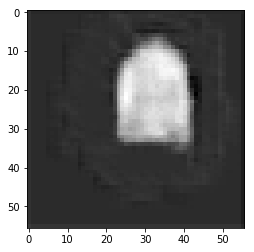

In [26]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

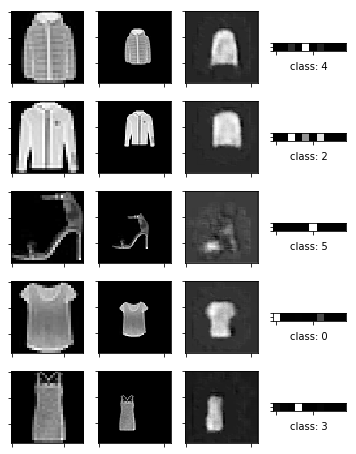

In [27]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_class,generator)

In [28]:
from src.metrics import var_expl
dxs = DL.dx[1]-14
dys = DL.dy[1]-14
dtheta = DL.dtheta[1]
fve_dx = var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = var_expl(features=z_enc,cond=dys,bins=21)
fve_dt = var_expl(features=z_enc,cond=dtheta,bins=21)

In [29]:
fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
fve_dy_norm = (dys.var()-fve_dy)/dys.var()
fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [30]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dx_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dx')
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dth_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dtheta')
plt.ylim(0.0,0.5)
np.argmax(fve_dth_norm.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[1,2],dtheta)